# Week of 2025.03.24

Goals for this week:
- [x] Add radiation damping to lumped parameter model.
- [ ] Figure out method for combing radiation damping and quasi static pressure to lumped parameter model.
- [x] Match lumped parameter model with quail numerical PDEs once the above are complete. 
- [ ] Modify toy problem for shorter time frame simulation, so that the radiation damping becomes a more important.
- [ ] Run monte carlo simulation to calculate parameter values ($\tau_p$, $\tau_r$, $D_c$) grounded by experimental data. 
- [ ] Update all $\tau_p$ to become $\tau_{peak}$

## 1.0 Review full ODE of slip

### 1.1 Viscous drag 

$$
\begin{align}
F_{visc} &= \int_0^{L_m} 2 \pi R \tau_{visc} dz \\
F_{visc} &= \int_0^{L_m} 2 \pi R \frac{4 u \mu}{R} dz \\
F_{visc} &= 8 \pi \mu \int_0^{L_m}  u dz \\
\end{align}
$$

Where 
$$
u = \frac{z}{L_m} * u_0 
$$

$$F_{visc} = 4 \pi \mu L_{melt} u_0$$

Where $u_0 = \dot{s}$

### 1.2 Radiation damping

[Mario's notes on radiation damping](https://drive.google.com/file/d/1pZ7jBqhoE9Qe85O8FSxsV6nznjUPBWEp/view?usp=sharing)

$$ 
\Delta p = -\rho c \dot{s}
$$

### 1.3 Quasi static state pressure reductions

$$
\Delta p = - \frac{K s}{L_{melt}}
$$

### 1.4 Effective Mass

Last week, Eric and Mario largely disregarded ineria as a significant factor. Furthermore, experimentally I found that added additional mass for the added mass effect led the lumped parameter model to oscillate more than we would expect prior to arriving at an equilibrium. If we did want to add effective mass we would use this equation.

$$
M_{eff} = M_{plug} (1 + \frac{L_{plug}}{2 L_{melt}})
$$

### 1.5 Frictional drag 
As a review, our current model uses either an exponential or linear friction model for $\tau$. 

**Linear model:**
$$ \tau(s) = \tau_p - (\tau_p - \tau_r) * \frac{s}{D_c} $$

**Exponential model:**
$$ \tau(s) = \tau_r - (\tau_r - \tau_p) \exp{-s/D_c}$$



### 1.6 System of ODEs

This system currently ignores the radiation damping term because the time frame our simulation takes place over is better simulated with the quasi steady state solution I believe. 


$$
\begin{align}
s_2 &= \dot{s_1} \\
\dot{s_2} &= \frac{1}{M_plug} [A * (p_0 - p_{atm} - \frac{K s_1}{L_{melt}})  - \tau (s_1) * 2 \pi R (L_{plug}-s_1) - 4 \pi \mu L_{melt} * s_2] \\
\end{align}
$$


## 2.0 Lumped parameter model

D_c: 3.3


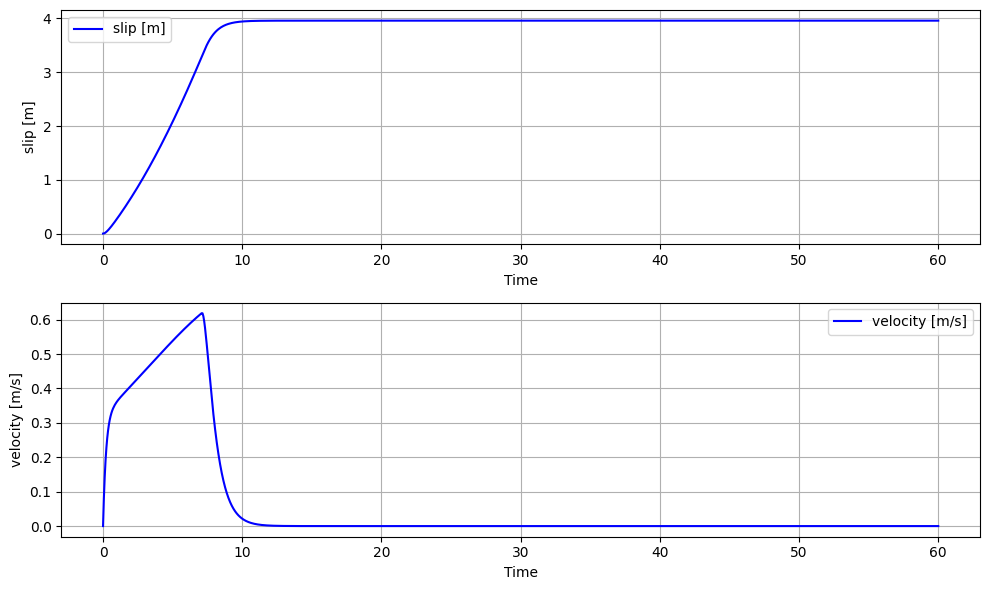

Slip: 3.9600
Velocity: -0.0000


In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from slip_imports import *

# Define constants (you can modify these values as needed)
K = 1e9      # Some constant (friction/damping)
L_melt = 900 # Melt length
tau_p = 2e5  # principle shear stress
tau_r = 0  # residual shear stress
R = 10      # Radius [m]
L_plug = 100 # Plug length

rho = 2.6e3  # Density

M_plug = R**2 * np.pi * L_plug * rho    # Mass
C = 600 # [m/s] Speed of sound in magma 

# Account for adding mass effect.
M_eff = M_plug * (1 + L_melt / (L_plug*2))
D_c = 3.3

# visocity
mu = 5e4

A = np.pi * R**2  # Cross-sectional area
p0 = 4.5e6  # Pressure at the top of the conduit
p_atm = 1e5  # Atmospheric pressure

NON_PHYSICAL_VISCOUS_FRICTION_MULTIPLIER = 0.65

def tau(s):
    #return tau_r - (tau_r - tau_p) * np.exp(s / D_c)

    if s < D_c:
        return tau_p - (tau_p - tau_r) * s / D_c
    else:
        return tau_r

# Define the system of differential equations
def system(state, t):
    s1, s2 = state  # s1 is position, s2 is velocity
    
    # ds1/dt = s2
    ds1_dt = s2
    
    ds2_dt =  (-A * K * s1) / (M_plug * L_melt) + \
            (A * (p0 - p_atm) / M_plug) + \
             - (tau(s1) * 2 * np.pi * R * (L_plug - s1)) / M_plug - \
             NON_PHYSICAL_VISCOUS_FRICTION_MULTIPLIER * 4 * np.pi * mu * L_melt * s2 / M_plug \
             #C * rho* s2 / M_plug
            
    return [ds1_dt, ds2_dt]

# Initial conditions
s1_0 = 0.0  # Initial position
s2_0 = 0.0  # Initial velocity
initial_state = [s1_0, s2_0]

# Time points
t = np.linspace(0, 60, 1000)  # Time from 0 to 10 with 1000 points

# Solve the differential equations
solution = odeint(system, initial_state, t)

# Extract solutions
s1 = solution[:, 0]  # Position
s2 = solution[:, 1]  # Velocity

# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, s1, 'b-', label='slip [m]')
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('slip [m]')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, s2, 'b-', label='velocity [m/s]')
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('velocity [m/s]')
plt.legend()

print(f"D_c: {D_c}")
plt.tight_layout()
plt.show()

# Optional: Print some key values
print(f"Slip: {s1[-1]:.4f}")
print(f"Velocity: {s2[-1]:.4f}")

## 2.2 Lumped parameter model compared to quail simulation
1. $P_0 = 4.5 Pa$ of pressure in the melt
2. $D_c = 3.3$
3. $\mu = 5e4$ (smaller than the viscosity in the quail model I think)
4. $\tau_p = 2e5$
5. $\tau_r = 0$

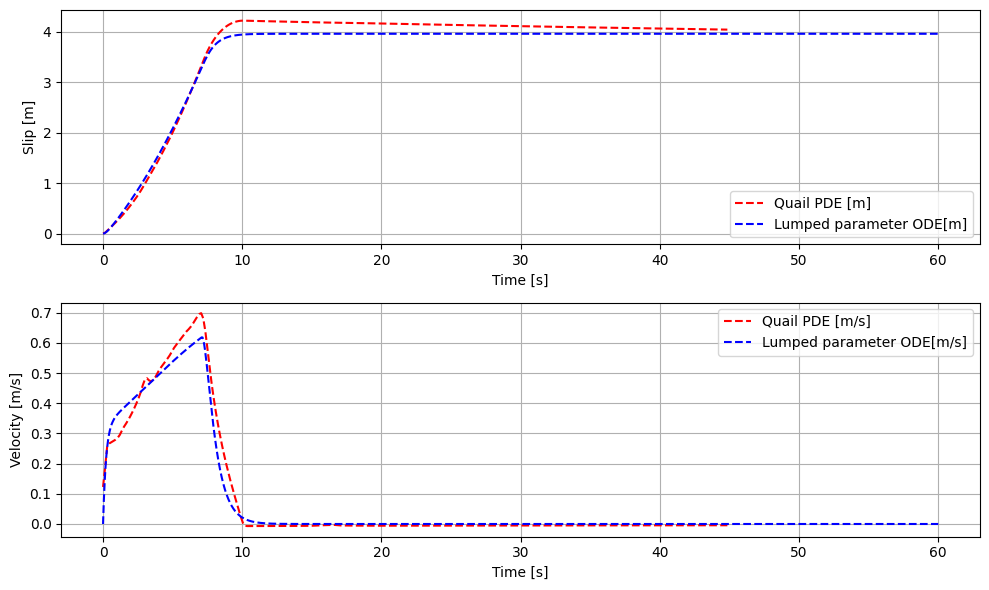

In [8]:
folder = "slip_variable_addition"
file_prefix = "short_plug_v9"
N = 300
viscosity_index = 2
slip_time_series = []
times = []

for i in range(0, N):
    solver = readwritedatafiles.read_data_file(f"{folder}/{file_prefix}_{i}.pkl")
    arhoA = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityA")]
    arhoWt = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWt")]
    arhoWv = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWv")]
    arhoC = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityC")]
    arhoM = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityM")]
    arhoF = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityFm")]

	# Get the value of the new state variable.
    rho_mix = arhoA + arhoWv + arhoM + arhoF
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
		
    # Get the value of the new state variable.
    slip_time_series.append((solver.state_coeffs[:,:,solver.physics.get_state_index("slip")]/rho_mix).ravel()[-1])
    times.append(solver.time)

ds_dt_quail = np.gradient(slip_time_series, times)

# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(times, slip_time_series, 'r--', label='Quail PDE [m]')
plt.plot(t, s1, 'b--', label='Lumped parameter ODE[m]')
plt.xlabel("Time [s]")
plt.ylabel("Slip [m]")
plt.grid(True)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(times, ds_dt_quail, 'r--', label='Quail PDE [m/s]')
plt.plot(t, s2, 'b--', label='Lumped parameter ODE[m/s]')
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

## 2.4 Radiation damping vs steady state analysis 

Let's evaluate the relative pressure deltas predicted by radiation damping and steady state analysis over time: 

**State case:** $\Delta p_S = \frac{-s K}{L_{melt}}$ 

**Radiation damping case:** $\Delta p_r = - \rho c \dot{s}$

Comparing the ratio of those forces we get:


$$ \frac{\Delta p_s}{\Delta p_R} = \frac{K}{L_m C \rho} \frac{s}{\dot{s}}$$

If we plot that for the quail PDE simulation we get:

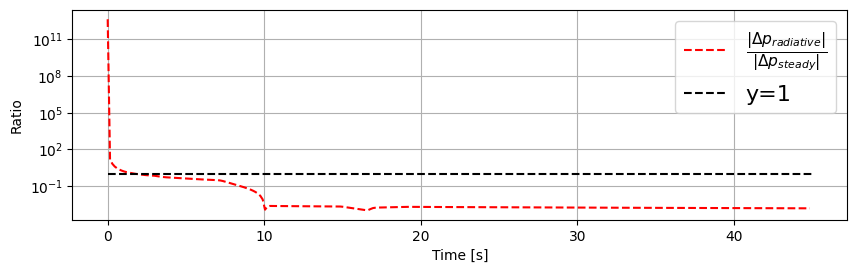

In [11]:
ds_dt_quail = np.gradient(slip_time_series, times)

delta_p_s = np.asarray(slip_time_series) * (K / L_melt)
delta_p_r = rho * C * ds_dt_quail

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)

plt.plot(times, np.abs(delta_p_r)/np.abs(delta_p_s), 'r--', label='$\\frac{|\\Delta p_{radiative}|}{|\\Delta p_{steady}|}$')
plt.hlines(1, 0, 45, colors='k', linestyles='dashed', label='y=1')
plt.xlabel('Time [s]')
plt.ylabel("Ratio")
plt.yscale("log")
plt.legend(fontsize=16)
plt.grid(True)




In [ ]:
print("Constants in front of velocity:")
print(f"viscous friction {4 * np.pi * mu * L_melt / 1e6} MPa")
print(f"radiative damping {rho * C / 1e6} MPa")

constants in front of velocity:
viscous friction 596.9026041820606 MPa
radiative damping 1.56 MPa


If I understand the output of this graph correctly, I believe this implies that the in my toy example the quasi static pressure law predicts a much larger $\Delta p$ than the radiation damping case. 

## 4.0 Updating toy problem to be in a shorter timescale regime

Mario expects the volcano eruption we are modeling to happen on the order of 1s. In order to have our toy problem better match that short timescale eruption, I am reducing the time frame of the eruption by increasing the pressure in the melt. 

$\tau_{peak} = 1e6$

$$
p_0 = p_{atm} + \frac{2 L \tau_p}{R} \\
p_0 = 1e5 + \frac{2 * 50 [m] * 1e6 [Pa]}{10 [m]} \\
p_0 = 10.1 MPa
$$

From our analysis on $D_c$ (ignoring viscous drag and assuming quasi static pressure drop) we know:

$$
\begin{align}
D_c &< \frac{2 L_{conduit} L_{plug} (\tau_p - \tau_r)}{R K } \\
D_c &< \frac{2 * 950m * 50m * 1e6 Pa}{10m * 1e9 Pa}  \\
D_c &< 9.5m
\end{align}
$$

I therefore set $D_c = 7$, which is substantially less than 9.5 to make up for the fact that the viscous friction term is not included. 




In [14]:
from slip_imports import *

ani = animate.animate_conduit_pressure("slip_variable_addition", iterations=25, file_prefix="short_plug_v10", p0=10.1, slip_final=7, max_tau=1.5)

HTML(ani.to_html5_video())

/Users/paxton/git/quail_volcano/scenarios/simple_1D_test


### 4.1 Lumper parameter model for more rapid eruption

In [37]:
from scipy.integrate import odeint

# Define constants (you can modify these values as needed)
K = 1e9      # Some constant (friction/damping)
L_melt = 950 # Melt length
tau_peak = 1e6  # principle shear stress
tau_r = 0  # residual shear stress
R = 10      # Radius [m]
L_plug = 50 # Plug length

rho = 2.6e3  # Density

M_plug = R**2 * np.pi * L_plug * rho    # Mass
C = 600 # [m/s] Speed of sound in magma 

# Account for adding mass effect.
M_eff = M_plug * (1 + L_melt / (L_plug*2))
D_c = 7

# visocity
mu = 5e4

A = np.pi * R**2  # Cross-sectional area
p0 = 1.1e7  # Pressure at the top of the conduit
p_atm = 1e5  # Atmospheric pressure


NON_PHYSICAL_VISCOUS_FRICTION_MULTIPLIER = 0.8

def tau(s):
    #return tau_r - (tau_r - tau_p) * np.exp(s / D_c)

    if s < D_c:
        return tau_peak - (tau_peak - tau_r) * s / D_c
    else:
        return tau_r

# Define the system of differential equations
def system(state, t):
    s1, s2 = state  # s1 is position, s2 is velocity
    
    # ds1/dt = s2
    ds1_dt = s2
    
    # ds2/dt = (-A*K*s2)/(M*L_melt) + ((tau_p - tau_s)*2*pi*R*(L_plug - s1)*s1)/M
    ds2_dt =  (-A * K * s1) / (M_plug * L_melt) + \
            (A * (p0 - p_atm) / M_plug) + \
             - (tau(s1) * 2 * np.pi * R * (L_plug - s1)) / M_plug - \
             NON_PHYSICAL_VISCOUS_FRICTION_MULTIPLIER * 4 * np.pi * mu * L_melt * s2 / M_plug \
             
    
    return [ds1_dt, ds2_dt]

# Time points
t = np.linspace(0, 30, 1000)  # Time from 0 to 10 with 1000 points

# Initial conditions
s1_0 = 0.0  # Initial position
s2_0 = 0.0  # Initial velocity
initial_state = [s1_0, s2_0]

# Solve the differential equations
solution = odeint(system, initial_state, t)

# Extract solutions
s1 = solution[:, 0]  # Position
s2 = solution[:, 1]  # Velocity

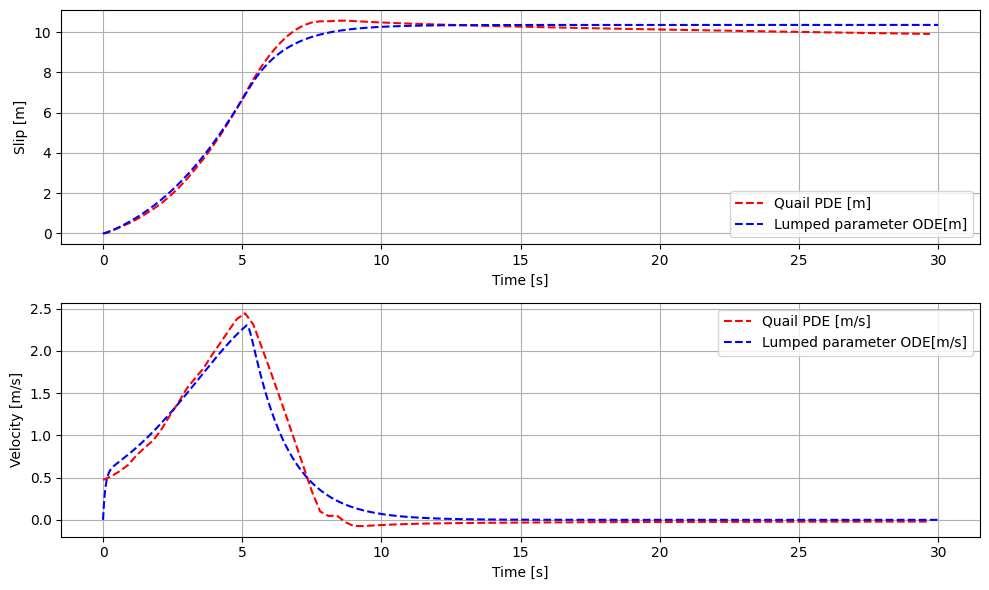

In [38]:
folder = "slip_variable_addition"
file_prefix = "short_plug_v10"
N = 100
viscosity_index = 2
slip_time_series = []
times = []

for i in range(0, N):
    solver = readwritedatafiles.read_data_file(f"{folder}/{file_prefix}_{i}.pkl")
    arhoA = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityA")]
    arhoWt = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWt")]
    arhoWv = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWv")]
    arhoC = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityC")]
    arhoM = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityM")]
    arhoF = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityFm")]

	# Get the value of the new state variable.
    rho_mix = arhoA + arhoWv + arhoM + arhoF
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
		
    # Get the value of the new state variable.
    slip_time_series.append((solver.state_coeffs[:,:,solver.physics.get_state_index("slip")]/rho_mix).ravel()[-1])
    times.append(solver.time)

ds_dt_quail = np.gradient(slip_time_series, times)

# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(times, slip_time_series, 'r--', label='Quail PDE [m]')
plt.plot(t, s1, 'b--', label='Lumped parameter ODE[m]')
plt.xlabel("Time [s]")
plt.ylabel("Slip [m]")
plt.grid(True)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(times, ds_dt_quail, 'r--', label='Quail PDE [m/s]')
plt.plot(t, s2, 'b--', label='Lumped parameter ODE[m/s]')
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

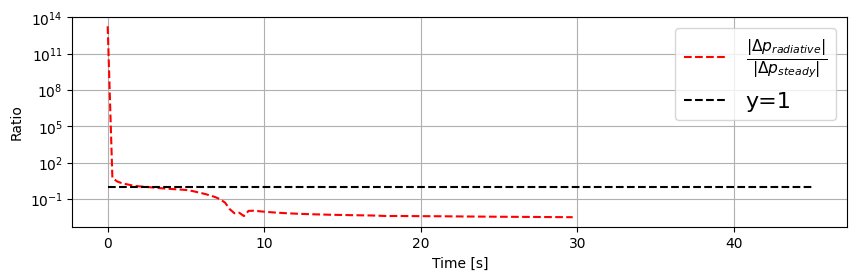

In [39]:
ds_dt_quail = np.gradient(slip_time_series, times)

delta_p_s = np.asarray(slip_time_series) * (K / L_melt)
delta_p_r = rho * C * ds_dt_quail

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)

plt.plot(times, np.abs(delta_p_r)/np.abs(delta_p_s), 'r--', label='$\\frac{|\\Delta p_{radiative}|}{|\\Delta p_{steady}|}$')
plt.hlines(1, 0, 45, colors='k', linestyles='dashed', label='y=1')
plt.xlabel('Time [s]')
plt.ylabel("Ratio")
plt.yscale("log")
plt.legend(fontsize=16)
plt.grid(True)



## 5.0 Working with Mario to make sure slip is working correctly

In [ ]:
from slip_imports import *

ani = animate.animate_conduit_pressure("test_for_mario", iterations=25, file_prefix="short_plug_v10", p0=10.1, slip_final=7, max_tau=1.5)

HTML(ani.to_html5_video())

## Questions:
1. *When comparing the steady state pressure to the radiation damping pressure is it sufficient to just compare magnitudes?* Sufficient to compare magnitudes, so long as you believe both terms are legitimate. In this case we think that the each term is not full legitimate. It requires a bit more work to think through which term is legitimate. 

2. *It appears that the model without radiative damping is still doing pretty well. Is the simulated eruption still too long?* Follow up with Mario on how we should speed up the eruption.
3. *Why do we need to add a constant multiliper to our viscosity term?* Currently the value is 0.8. One possibility is that our assumption about a **linear** velocity profile is incorrect. It appears that the constant multiplier may go away when we change other parameters like $\tau_{peak}$.

4. *In order to get these eruptions to happen very suddenly I have a ton of pressure in the melt. It would probably be more physical to basically have the eruption be able to go with just a little bit of additional pressure. Is that a correct impulse?* Yes, I should never start with a pressure gradient with a sharp discontinuity. 